<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#k-NN" data-toc-modified-id="k-NN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>k-NN</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#k-NN-homemade-implementation" data-toc-modified-id="k-NN-homemade-implementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>k-NN homemade implementation</a></span></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Exercises</a></span><ul class="toc-item"><li><span><a href="#Exercise-1.1" data-toc-modified-id="Exercise-1.1-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Exercise 1.1</a></span></li><li><span><a href="#Exercise-1.2" data-toc-modified-id="Exercise-1.2-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Exercise 1.2</a></span></li><li><span><a href="#Exercise-1.3" data-toc-modified-id="Exercise-1.3-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Exercise 1.3</a></span></li><li><span><a href="#Exercise-1.4" data-toc-modified-id="Exercise-1.4-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Exercise 1.4</a></span></li><li><span><a href="#Exercise-1.5" data-toc-modified-id="Exercise-1.5-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>Exercise 1.5</a></span></li></ul></li></ul></li></ul></div>

# k-NN

This notebook illustrates on how to build your own k-NN classifier and practice with the outcome and the ideas from this nice and simple method!

In [15]:
from collections import defaultdict
from random import seed
from random import randrange
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

# These are tricks for better displaying info in notebooks
pd.set_option("display.max_columns", 1000)
pd.set_option("max_seq_items", 1000)
pd.set_option("display.width", 1000)
np.set_printoptions(threshold=np.inf)

# Set the global random seed to ensure reproducibility
np.random.seed(1234)
random.seed(1234)

## Dataset

One of the possibly best datasets to illustrate k-NN is the [prostate cancer dataset in Kaggle](https://www.kaggle.com/sajidsaifi/prostate-cancer). It contains only 100 samples, with a target variable which is categorical (`diagnosis_result`). The goal is to predict whether the result from an examination results in `M` (62%) or `B` (32%).

In the next _cell_ I read the CSV file (you must download it first!) and prepare everything to be ready for k-NN:
  - all features must be numerical (floats) and scaled.
  - target variable is also converted to numerical (B=0.0, M=1.0).

In [16]:
data = pd.read_csv("Prostate Cancer.csv")

# Convert int to floats for these columns
columns_to_convert = ["radius", "texture", "perimeter", "area"]
data[columns_to_convert] = data[columns_to_convert].astype(float)

# Convert target variable into a float
data.diagnosis_result = data.diagnosis_result.apply(
    lambda value: 0.0 if value == "B" else 1.0
)
# Use column called 'id' as index.
data = data.set_index("id")
data.head()

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
id,,,,,,,,,
1,1.0,23.0,12.0,151.0,954.0,0.143,0.278,0.242,0.079
2,0.0,9.0,13.0,133.0,1326.0,0.143,0.079,0.181,0.057
3,1.0,21.0,27.0,130.0,1203.0,0.125,0.160,0.207,0.060
4,1.0,14.0,16.0,78.0,386.0,0.070,0.284,0.260,0.097
5,1.0,9.0,19.0,135.0,1297.0,0.141,0.133,0.181,0.059


In [17]:
# Set a variable (features) with the names of all the features BUT the target variable.
target = "diagnosis_result"
features = list(set(data.columns) - set([target]))
print(f"The list of columns that represent features is:\n{features}")
print(f"So, we have {len(features)} dimensions in our feature vectors.")

scaler = RobustScaler().fit(data[features])
data[features] = scaler.transform(data[features]).round(4)

print()
data.head()

The list of columns that represent features is:
['perimeter', 'fractal_dimension', 'smoothness', 'area', 'compactness', 'symmetry', 'radius', 'texture']
So, we have 8 dimensions in our feature vectors.



,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
id,,,,,,,,,
1,1.0,0.6667,-0.6667,1.7953,0.7041,2.2162,2.0850,1.4054,1.6
2,0.0,-0.8889,-0.5455,1.2283,1.5491,2.2162,-0.5163,-0.2432,-0.6
3,1.0,0.4444,1.1515,1.1339,1.2697,1.2432,0.5425,0.4595,-0.3
4,1.0,-0.3333,-0.1818,-0.5039,-0.5860,-1.7297,2.1634,1.8919,3.4
5,1.0,-0.8889,0.1818,1.2913,1.4832,2.1081,0.1895,-0.2432,-0.4


## k-NN homemade implementation

Let's work on our own implementation of k-NN, simply to illustrate how simple is this method. Let's start by the distance function used: _euclidean distance_. For those of you who do not remember the math of the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between two points in $p$ dimensions:

$$ d(p, q)=d(q, p)=\sqrt{\left(q_{1}-p_{1}\right)^{2}+\cdots+\left(q_{n}-p_{n}\right)^{2}} $$

where $n$ is the number of features or dimensions or predictors, and $p, q$ are the two points or vectors. The implementation of this formula is as follows:

In [18]:
def euclidean_distance(p, q):
    distance = 0.0
    for i in range(len(p)):
        distance += (p[i] - q[i]) ** 2
    return sqrt(distance)

The way k-NN works is by pre-computing the distance between every pair of points/vectors in the data, and putting them in a matrix. By doing so, later determining who are the "k" nearest neighbors is easily done by taking a look at the matrix.

If, for example, we had three points, $a$, $b$ and $c$, the distance matrix $D$ is something like this:

$$
D=\left(\begin{array}{ccc}
0 & d(a, b) & d(a, c) \\
d(b, a) & 0 & d(b(c) \\
d(c, a) & d(c, b) & 0
\end{array}\right)
$$

In our case we have 100 different samples, which means that we have a matrix $D$ shaped $100 \times 100$.

In [19]:
def distance_matrix(data):
    n_samples = data.shape[0]
    D = np.ndarray((n_samples, n_samples))
    D_row = np.ndarray((n_samples,))

    for i in range(n_samples):
        for j in range(n_samples):
            D_row[j] = euclidean_distance(data.iloc[i].values, 
                                          data.iloc[j].values)
        D[i] = D_row

    return D

How to get the $k$ nearest beighbors of a particular sample that is not in training data? Well, instead of computing all the distances between all samples in training set, we only compute the distance between the sample we want to classify and all the data in our tratining set.

The method below is doing so. It needs all the training data, the point which needs to be classified, and the number of neighbours you want to return. The result is the index of the closest `num_neighbors` samples in training data, to our point.

In [20]:
def get_neighbors(data, point, num_neighbors: int):
    n_samples = data.shape[0]
    distances = list()
    for sample_index in range(n_samples):
        this_point = data.iloc[sample_index]
        distance = euclidean_distance(this_point, point)
        distances.append((sample_index, distance))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])

    return [d[1] for d in distances[:num_neighbors]], neighbors

To illustrate this idea, simply take a random sample with 8 values and call the method. The result is the list of closets neighbours to this samples, according to the euclidena distance.

In [21]:
sample = [1.0, 1.0, 1.0, 1.0, 7.0, 1.0, 1.0, 1.0]
get_neighbors(data[features], sample, 3)

([4.768526774591918, 5.456166537047784, 5.826941259357262], [78, 0, 12])

If we compare our result with what the kNN implementation in Scikit-Learn produces, we can check that we're correct.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn.fit(X=data[features], y=data[target])
knn.kneighbors(X=[sample])

(array([[4.76852677, 5.45616654, 5.82694126]]), array([[78,  0, 12]]))

How to make a prediction from this? Simply taking the value of the target variable for the samples selected. The next method implements this Max Voting scheme. Once we have $k$ individuals that are close to the sample we want to classify, we need to determine which is the label of the majority of them. That is what the `max(...)` part inside the method implements.

In [23]:
# Make a prediction with neighbors
def predict_classification(data, features, sample, num_neighbors):
    # Obtain the closest neighbours for this sample
    neighbors = get_neighbors(data[features], sample, num_neighbors)[1]

    # from the list of samples that are closer to it, obtain the value of the
    # target variable
    output_values = [data.iloc[i][target] for i in neighbors]

    # This is simplified Max Voting function that determines what label is
    # most commonly present among the "k" neighbors
    prediction = max(set(output_values), key=output_values.count)

    return prediction

Finally, we need a method to wrap everything.

In [24]:
# kNN Algorithm
def k_nearest_neighbors(data, features, test, num_neighbors):
    predictions = list()
    for row in test:
        output = predict_classification(data, features, row, num_neighbors)
        predictions.append(output)
    return predictions

The way we call it is by giving the method the data, the names of the features, the sample(s) we want to classify, and the number of neighbours to be used:

(we use `[sample]` because the method expects a list of samples to be classified but we only have one... so we create a list with that only sample in it.)

In [25]:
k_nearest_neighbors(data, features, [sample], 3)

[1.0]

## Exercises

  1. We have presented the $D$ matrix, in the method `distance_matrix`. Can we use it to classify a new sample which is not in the training set?
  2. We have a problem with 8-dimensions, which is rather difficult to plot... but, can you make an extreme feature selection to keep only the two most important features, and use them to plot the 100 samples in those two dimensions? Can you use the value of the target variable to plot each point in a different color? Is the distribution showing up a discernible separation boundary?
  3. What is the optimal number for $k$ in our original problem? To do this you must split the dataset between training and test in order to evaluate (using cross validation!) what is the performance (what metric do you plan to use?) of the different values of $k$.
  4. Can you compare your results in previous point with those produced by the `sklearn` impmlementation of k-NN?
  5. **EXTRA** Can you evaluate any other distance function different to `euclidean`?

### Exercise 1.1

We have presented the $D$ matrix, in the method `distance_matrix`. Can we use it to classify a new sample which is not in the training set?

  Well, NO, we cannot. The matrix $D$ only contains the distance to the points/vectors used as reference for the algorithm. These reference points are the equivalent of the _training set_. If we want to _classify a new sample_ (or point, or vector, or feature vector, or entry, or row, or ... you name it) we must know its distance to all the samples in the reference/training set. And since this point is new to the model, we don't have its distance computed in the matrix $D$.

### Exercise 1.2

  _We have a problem with 8-dimensions, which is rather difficult to plot... but, can you make an extreme feature selection to keep only the two most important features, and use them to plot the 100 samples in those two dimensions? Can you use the value of the target variable to plot each point in a different color? Is the distribution showing up a discernible separation boundary?_

We will use a decision tree to see what features are more important. Remember that once a tree is _fit_ (or trained) we can recover _feature importances_ by checking out that parameter in `sklearn`. To be sure that the approach works we must use using cross_validation. This is, we cannot rely on the first attemp to fit a decision tree on the entire data. We must select different subsets.

So, first of all we need a method that will separate the features from the target variable in a given split.

In [26]:
def assign_data_to_fold(data, training_fold):
    X_train = data.iloc[training_fold][features]
    y_train = data.iloc[training_fold][target]
    return X_train, y_train

We also need a method that will fit a decision tree with the selected training split (X, y) and will extract `feature_importances_`. Since `sklearn` is returning the importance value, and what we need is the index of the features with the two-higher importances, we must work a little bit the indices.

In [27]:
def two_most_important_features(X_train, y_train):
    tree = DecisionTreeClassifier().fit(X_train, y_train)
    feat_imp = list(tree.feature_importances_)

    # Sort the importances and take only the first two ([:2])
    higher_importances = sorted(list(feat_imp), reverse=True)[:2]

    # Recover the index of the features with those values, as that is what is
    # telling us what features are more important (not the value). We use
    #  the method `index()` to do so.
    best = feat_imp.index(higher_importances[0])
    second_best = feat_imp.index(higher_importances[1])

    return best, second_best

Once we know what features are the most important in a given split, we upvote for them. If we do so during all the splits generated, we will collect how many times each category result among the first two most important.

In [28]:
def vote_winner_categories(polling, votes):
    polling[votes[0]] += 1
    polling[votes[1]] += 1

    return polling

Finally, a loop to generate the votes for all the splits and collect at the end which categories present more votes. We use the `KFold` ([more info](https://scikit-learn.org/stable/modules/cross_validation.html)) to generate as many folds as required (50). For each on, we take the training portion to fit a tree and extract the most important features, to finally keep track of how many votes each category receives along the process.

The final result is the list of the two most important features, at least for the decision tree classifier.

In [29]:
# Generate this number of folds or splits
n_splits = 50
kfold = KFold(n_splits)
# This will collects what features are more important on every fold.
polling = defaultdict(int)

for training_fold, _ in kfold.split(data):
    X_train, y_train = assign_data_to_fold(data, training_fold)
    important_features = two_most_important_features(X_train, y_train)
    polling = vote_winner_categories(polling, important_features)

most_important_features = sorted(polling, key=polling.get, reverse=True)[:2]
print(f"Most important features: {most_important_features}")

feat1 = features[most_important_features[0]]
feat2 = features[most_important_features[1]]
print(f"Names of the features: {feat1}, {feat2}")

Most important features: [0, 4]
Names of the features: perimeter, compactness


Now plot only those two features in a 2D chart, using different colors for each category.

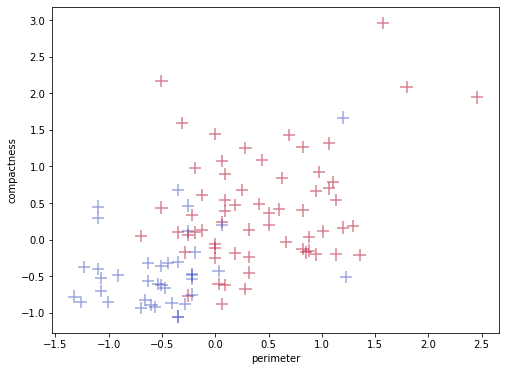

In [30]:
x = data[feat1].values
y = data[feat2].values
color = data[target].astype(int)

plt.figure(figsize=(8, 6))
plt.scatter(
    x, y, marker="+", s=150, linewidths=4, c=color, cmap=plt.cm.coolwarm, alpha=0.5
)
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.show()

### Exercise 1.3

What is the optimal number for $k$ in our original problem? To do this you must split the dataset between training and test in order to evaluate (using cross validation!) what is the performance (what metric do you plan to use?) of the different values of $k$.

Reusing our `KFold` function we can generate different splits and evaluate the **accuracy** of our home made implementation, for different values of $k$.

In [35]:
def evaluate_homemade_knn(data, num_neighbors):
    n_splits = 20
    kfold = KFold(n_splits)
    accuracies = []  #  <- used to store each individual accuracy

    for training_fold, test_fold in kfold.split(data):
        train = data.iloc[training_fold, :]
        test = data.iloc[test_fold, :]
        y_true = test[target]
        y_pred = k_nearest_neighbors(train, features, 
                                     test[features].values, 
                                     num_neighbors)
        accuracies.append(accuracy_score(y_true, y_pred))

    return np.mean(accuracies)

Evaluate for different values of $k$ and keep the score at each evaluation to later plot.

As it is a bit slow (the implemenation can clearly improve) uncomment if you're decided to wait for a few seconds.

In [36]:
score = [evaluate_homemade_knn(data, k) for k in range(3, 20, 2)]

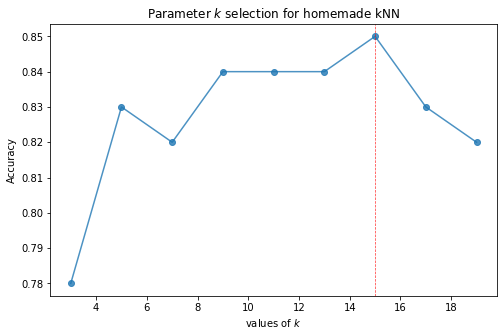

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(range(3, 20, 2), score, "o-", alpha=0.8)
plt.axvline(
    x=(score.index(max(score)) * 2) + 3, c="r", linestyle="--", linewidth=0.7, alpha=0.8
)
plt.title("Parameter $k$ selection for homemade kNN")
plt.xlabel("values of $k$")
plt.ylabel("Accuracy")
plt.show()

### Exercise 1.4

Can you compare your results in previous point with those produced by the `sklearn` impmlementation of k-NN?

We simply have to create the classifier using the class `KNeighborsClassifier` and passing the desired number of neighbors (default = 5) and the distance method to be used (default=_minkowski_). 

Using SKLearn is much easier than building the method on your own, so we don't have to use complicated methods to split the dataset. We can easily call the `cross_val_score` which will take care of the entire process for us. You can read more [here](https://scikit-learn.org/stable/modules/cross_validation.html).

In [40]:
def evaluate_sk_knn(data, n_neighbors):
    knn = KNeighborsClassifier(n_neighbors, metric="euclidean")
    scores = cross_val_score(
        knn, data[features], data[target], cv=10, scoring="accuracy"
    )
    return scores.mean()


sk_scores = [evaluate_sk_knn(data, k) for k in range(3, 20, 2)]

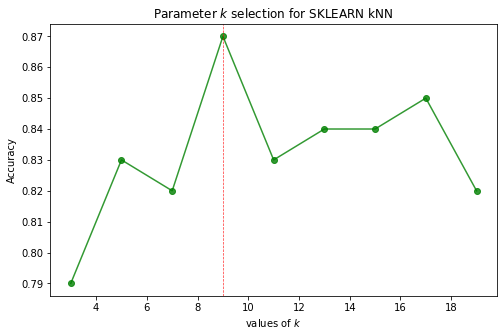

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(range(3, 20, 2), sk_scores, c="green", marker="o", alpha=0.8)
plt.axvline(
    x=(sk_scores.index(max(sk_scores)) * 2) + 3,
    c="r",
    linestyle="--",
    linewidth=0.7,
    alpha=0.8,
)
plt.title("Parameter $k$ selection for SKLEARN kNN")
plt.xlabel("values of $k$")
plt.ylabel("Accuracy")
plt.show()

### Exercise 1.5

**EXTRA** Can you evaluate any other distance function different to `euclidean`?

As we just saw, we can change the parameter `metric` in `KNeigborsClassifier` and use any of the distances specified [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric).

If you decide to implement those for our homemade kNN, try googling it first, as there're [many](https://www.geeksforgeeks.org/minkowski-distance-python/) existing implementations already.